## Dataset and packages import + Initial dataset exploration

**IMPORTANT: We have used the terminal to download additional libraries that were not initially present in the instructions given by using the command ```python -m pip install (library)```. That is why many librares like WordCloud or mpld3 may not work in default settings of the ```pminsky-lab-dev``` kernel.**

In [36]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpld3

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

import seaborn as sns

from IPython.display import HTML, JSON
import sklearn.metrics
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from io import BytesIO

In [37]:
train=pd.read_csv("agnews_train.csv")
test=pd.read_csv("agnews_test.csv")

In [38]:
train.head()

,text,label,label_int,science_int,sports_int,world_int,business_int
0,"John Souza, a volunteer with the Boone County ...",Business,3,0,0,0,1
1,Spain needs only to beat an under-strength Fre...,Sports,1,0,1,0,0
2,"PANAMA CITY, Panama -- When the United States ...",World,2,0,0,1,0
3,"Gilbert Arenas, Jarvis Hayes and Anthony Peele...",Sports,1,0,1,0,0
4,"MEMPHIS, Tenn. -- Kobe Bryant had his worst sh...",Sports,1,0,1,0,0


In [39]:
test.head()

,text,label,label_int,science_int,sports_int,world_int,business_int
0,It #39;s over. Our relationship just hasn #39;...,Science,0,1,0,0,0
1,Toshiba Corp. announced Tuesday a 80 gigabyte ...,Science,0,1,0,0,0
2,Scientists go back to the drawing board in the...,Science,0,1,0,0,0
3,The first shuttle flight since the Columbia tr...,Science,0,1,0,0,0
4,"NEW YORK, Sept 21: Iraqi Prime Minister Iyad A...",World,2,0,0,1,0


In [40]:
print(f'The test dataset has a shape of {test.shape}, and the train set {train.shape}.' )

print(f'We observe both train ({train.isnull().any().sum()}) and test ({train.isnull().any().sum()}) do not have missing values.')

The test dataset has a shape of (10000, 7), and the train set (109999, 7).
We observe both train (0) and test (0) do not have missing values.


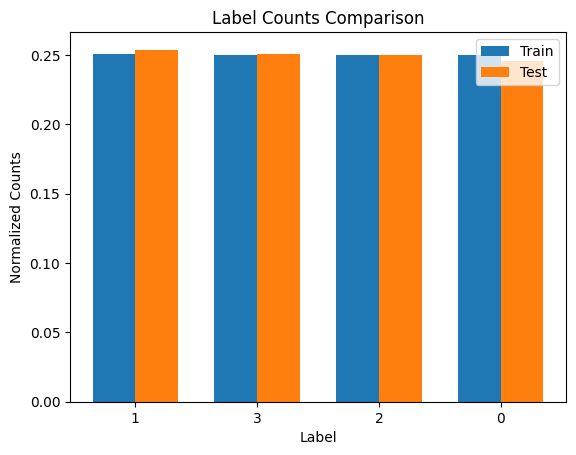

In [41]:
# We can see that they are indeed balanced by simply plotting "label_int" distribution using value_counts
# normalized.

train_label_counts = train["label_int"].value_counts(normalize=True)
test_label_counts = test["label_int"].value_counts(normalize=True)

bar_width = 0.35
x_train = np.arange(len(train_label_counts))
x_test = [x + bar_width for x in x_train]

fig, ax = plt.subplots()
ax.bar(x_train, train_label_counts, width=bar_width, label='Train')
ax.bar(x_test, test_label_counts, width=bar_width, label='Test')
ax.set_xlabel('Label')
ax.set_ylabel('Normalized Counts')
ax.set_title('Label Counts Comparison')
ax.set_xticks(x_train + bar_width / 2)
ax.set_xticklabels(train_label_counts.index)
ax.legend()
plt.show()

Great, no imbalance and no missing values. Let's now go to the word level... What is the frequency of words? Making use of the in-class example, we will apply a tokenizer which is part of the ```feature.extraction.text``` module from ```sklearn``` library, which for a first exploration may be good (as it gets rid of commas and many common language terms that may not yield significant feedback when exploring).

In [42]:
# For doing so, we first apply a function to call it

def initial_sklearn_analyzer():
    #We leave stop_words with the ones by default
    vect=CountVectorizer(stop_words=[])
    analyzer=vect.build_analyzer()
    return analyzer

#We instantiate our model
sk_analyzer = initial_sklearn_analyzer()

In [43]:
#Turn to see the words distribution. Let's count them in both train and test sets.

word_counts=Counter()
for element in [train, test]:
    for text in element.text:
        word_counts.update(sk_analyzer(text))
        
print(f'In total, we have {len(word_counts.most_common())} words in both datasets.')

In total, we have 60741 words in both datasets.


In [44]:
#And what about the amount and most common ones for each? Let's first do train set.
word_counts=Counter()
for text in train.text:
    word_counts.update(sk_analyzer(text))
    
print(f' Train set has {len(word_counts.most_common())} words.')

#And for top 20 words in frequency terms...
word_counts.most_common(20)

 Train set has 58831 words.


[('the', 182263),
 ('to', 88925),
 ('of', 82101),
 ('in', 72156),
 ('and', 60998),
 ('on', 44011),
 ('for', 35113),
 ('39', 29262),
 ('that', 25467),
 ('with', 20823),
 ('as', 20126),
 ('its', 19440),
 ('at', 19076),
 ('said', 18413),
 ('is', 18395),
 ('it', 17558),
 ('by', 17201),
 ('has', 16768),
 ('new', 16005),
 ('an', 15241)]

In [45]:
#As we instantiated the class, we have to reinstantiate in order to only take into account the test set.
word_counts=Counter()
for text in test.text:
    word_counts.update(sk_analyzer(text))

print(f' Test set has {len(word_counts.most_common())} words.')

#And for top 20 words in frequency terms...
word_counts.most_common(20)

 Test set has 22748 words.


[('the', 16771),
 ('to', 7901),
 ('of', 7472),
 ('in', 6598),
 ('and', 5622),
 ('on', 4059),
 ('for', 3110),
 ('39', 2612),
 ('that', 2321),
 ('with', 1899),
 ('its', 1826),
 ('as', 1800),
 ('at', 1758),
 ('said', 1685),
 ('it', 1613),
 ('is', 1599),
 ('by', 1569),
 ('has', 1533),
 ('new', 1389),
 ('from', 1344)]

In order to fully understand such dimensionality, let's do a wordcloud for each set. We will see how this non-semantic words play a pivotal role relative to others in both sets when it comes to frequency.

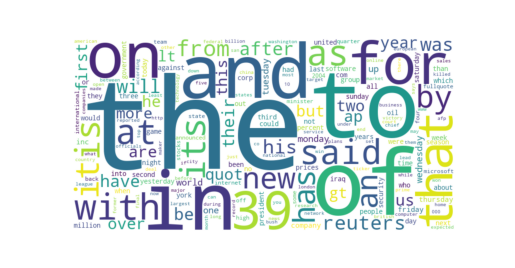

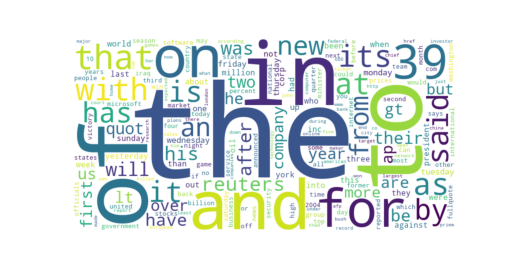

In [46]:
datasets = [train, test]

for dataset in datasets:
    word_counts = Counter()
    for text in dataset.text:
        word_counts.update(sk_analyzer(text))

    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis')
    wordcloud.generate_from_frequencies(word_counts)
    image_width, image_height = wordcloud.width, wordcloud.height

    # We create a figure with dimensions matching the word cloud image and reducing the pixels
    fig, ax = plt.subplots(figsize=(image_width/100, image_height/100), dpi=400)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_axis_off()

    # We create a tooltip function to display the frequency and rank
    def tooltip_text(word, font_size, position, orientation, random_state=None, **kwargs):
        frequency = word_counts[word]
        rank = sorted(word_counts, key=word_counts.get, reverse=True).index(word) + 1
        return f'Word: {word}\nFrequency: {frequency}\nRank: {rank}'
    mpld3.plugins.connect(fig, mpld3.plugins.PointHTMLTooltip(wordcloud, tooltip_text))

    # We save the plot to a BytesIO object for display
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    plt.close(fig)
    buffer.seek(0)
    img = buffer.getvalue()
    plt.imshow(plt.imread(BytesIO(img)))
    plt.axis('off')
    plt.show()

<div class="alert alert-block alert-danger">
<b>First conclusion:</b> Top frequency words are conjunctions, prepositions... for both train and test set. We have to go to deeper meanings or even n-grams if we want to find an approach that yields semantic identification with the features.
</div>

# Bag-of-words Naive Bayes and SGD classifiers: understanding in a multicalss context which features are more difficult to predict

We will try out a bag-of-words from the linear perspective (```SGDClassifier```) and a Naive Bayes approach (```MultinomialNB```). Both of them will encode inside a ```pipeline``` three different components that will be of utility:

> **```CountVectorizer()```**: Creates a vector (or bag-of-words) from the text.

> **```TfidfTransformer()```**: Assigns frequencies to the words, weighting at the same time those that appear too much by applying the logarithmic scale on it (a brief explanation of the formula below is displayed).

> **```clf```** : Will apply the respective algorithm (```SGDClassifier``` or ```MultinomialNB```) and extract the words weights assigned during training.


TFIDF (Term Frequency Inverse Document Frequency)
- TFIDF = TF * IDF
- TF = #occurrences of term
- How frequent is the term occurring in the document?
- IDF = log (#documents / #documents with term)
- How rare is the term to be in a document?

In [58]:
# Let's begin by creating a function encoding inside the pipeline each of the two functions.

#Naive bayes
def make_sklearn_naive_bayes():
    classifier = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB()),
    ])
    return classifier

#The linear model, sgd
def make_sklearn_sgd():
    classifier = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='hinge', penalty='l2',
                              alpha=1e-3, random_state=42,
                              max_iter=5, tol=None)),
        ])
    return classifier

## Naive Bayes: Model creation and classification report + confusion matrix

In [59]:
# Reviewing the news by calling our function on the label_int column (which encodes all news types)

#We fit our model
naive_bayes=make_sklearn_naive_bayes().fit(train.text, train.label_int)
naive_bayes

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [91]:
#We will define two functions: one for displaying a classification report and 
#confusion matrix for a multiclass problem, and another for binary.

def results_multiclass(model_fit):
    predictions = model_fit.predict(test.text)

    # We print classification report
    report = classification_report(test.label_int, predictions,
                                   target_names=["science", "sports", "world", "business"])
    print(report)

    # We also create a colourful confusion matrix
    cm = confusion_matrix(test.label_int, predictions)
    cmap = "viridis"
    sns.heatmap(cm, annot=True, cmap=cmap, fmt="d", xticklabels=["science", "sports", "world", "business"],
                yticklabels=["science", "sports", "world", "business"])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
def results_binary(model_fit, variable):
    predictions = model_fit.predict(test.text)

    # We print classification report
    report = classification_report(test[variable], predictions)
    print(report)

    # We also create a colourful confusion matrix
    cm = confusion_matrix(test[variable], predictions)
    cmap = "viridis"
    sns.heatmap(cm, annot=True, cmap=cmap, fmt="d")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

              precision    recall  f1-score   support

     science       0.88      0.86      0.87      2537
      sports       0.95      0.98      0.96      2458
       world       0.90      0.89      0.89      2509
    business       0.86      0.86      0.86      2496

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



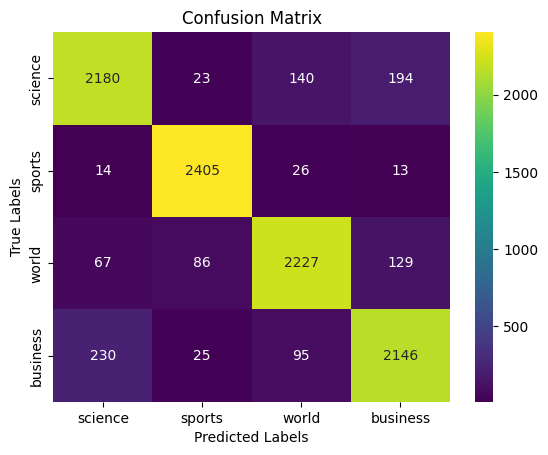

In [61]:
#We predict, and display the accuracy metrics with the classification report and confusion matrix

results_multiclass(model_fit=naive_bayes)

As we can see, the model has considerable levels of precision and recall, specially for sports news, with an overall precision of 90%. Nonetheless, this model is limiting the words importance extraction. Therefore, knowing that ```MultinomialNB()``` is particularly good at predicting sports news, we will move to repeat and expand the process with ```SGDClassifier()```.

## SDGClassifier: Model creation (+ hyperparameterization), confusion matrix, words weight, precision and recall

In [62]:
#We train a first model

sdg_model=make_sklearn_sgd().fit(train.text, train.label_int)
sdg_model

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

              precision    recall  f1-score   support

     science       0.86      0.80      0.83      2537
      sports       0.86      0.98      0.92      2458
       world       0.88      0.85      0.87      2509
    business       0.86      0.82      0.84      2496

    accuracy                           0.86     10000
   macro avg       0.86      0.87      0.86     10000
weighted avg       0.86      0.86      0.86     10000



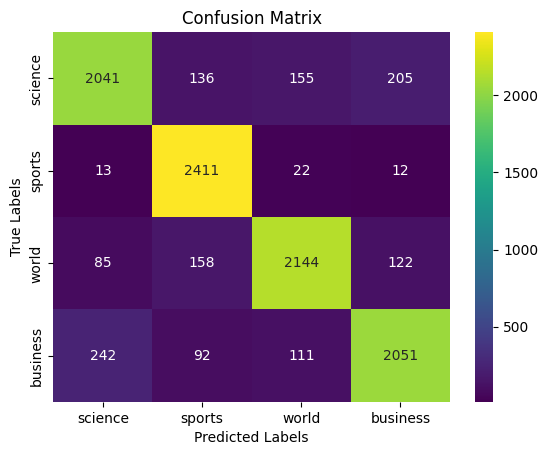

In [63]:
#We run a first model on the test set with the correspondent classification_report and confusion matrix
#calling the functions we created for doing so

results_multiclass(model_fit=sdg_model)

To be honest, that hurt (just a bit, but hurt). Our most explainable model in feature importance terms and understanding (as it is linear) it is not able to predict as well as the ```MultinomialNB()``` we just coded. This trend really does make sense in the machine learning world (this is explained in this arXiv article: <a href="https://arxiv.org/pdf/2010.13764.pdf">Enforcing Interpretability and its Statistical Impacts:
Trade-offs between Accuracy and Interpretability</a>.

There are multiple ways we can steer such metrics by changing our models, we will try two of them subsequently:

1. **N-grams**: adding pairs of words into our word vector space, so that it can also take them into account. We will try 1 as it is, 2 and 3 pairs (all of them are cumulative, so, 3 contains 2-grams and 1-grams).
2. **Hyperparameterization using ```GridSearchCV```**: to see if a different combination we can give more robustness to the model, so that future interpretations make even more sense.

Fortunately, the hyperparameterization can take into account N-grams as a hyperparameter on its own! Therefore, the next step is clear: Improving the accuracy of our model by analyzing the hyperparameters space so that words weight interpretations are more robust. For that, we will also use ```cross-validation``` of 5 folds inside the hyperparameterization process carried out inside ```GridSearchCV```. We will use the parameter ```n_jobs```equal to -2 in order to use more CPU power to speed up the computation process.

In order to do that, we will make use of the convenience function defined in class, which displays us a sorted dataframe showing the impact of the different hyperparameters. Then, we will make use of the exact set of hyperparameters to replicate the model and exract the feature importance.

In [64]:
def crossvalidation_report_df(grid_cv): 
    """Convenience  function. 
    
    Creates a simple dataframe that reports the results of a 
    cros-validation experiment. The input grid_cv must be fit. 
    
    Returns a dataframe, sorted by rank of experiment. 
    """
    # pick columns that define each experiment (start with param)
    # and the columns that report mean_test and rank_test results
    cols = [c for c in grid_cv.cv_results_ if (c.startswith('param') or 
                                               c in ['mean_test_score', 'rank_test_score'])]

    # sort original df by rank, and select columns
    return pd.DataFrame(grid_cv.cv_results_).sort_values(by='rank_test_score')[cols]


**IMPORTANT: The hyperparameters set makes the running time very long. Therefore, we decided to keep them as they are keeping in mind that even with the ```n_jobs``` being -1, the running time is slightly superior to 11 minutes.**

In [65]:
# this defines the base sklearn pipeline we want tot tune
sgd_grid_estimator = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', random_state=42, max_iter=100, tol=None)),
])

# this defines the configurations
sgd_grid_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1,3)],
    'clf__alpha': (1e-3, 1e-6, 1e-9, 1e-12)
}

# we create the grid
sgd_grid= GridSearchCV(sgd_grid_estimator, sgd_grid_parameters, verbose=1, n_jobs=-1)

In [66]:
sgd_grid.fit(train.text, train.label_int)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        SGDClassifier(max_iter=100,
                                                      random_state=42,
                                                      tol=None))]),
             n_jobs=-1,
             param_grid={'clf__alpha': (0.001, 1e-06, 1e-09, 1e-12),
                         'vect__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             verbose=1)

In [67]:
crossvalidation_report_df(sgd_grid)

,param_clf__alpha,param_vect__ngram_range,params,mean_test_score,rank_test_score
5,0.000001,"(1, 3)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1,...",0.912499,1
4,0.000001,"(1, 2)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1,...",0.910763,2
8,0.0,"(1, 3)","{'clf__alpha': 1e-09, 'vect__ngram_range': (1,...",0.906281,3
11,0.0,"(1, 3)","{'clf__alpha': 1e-12, 'vect__ngram_range': (1,...",0.905808,4
7,0.0,"(1, 2)","{'clf__alpha': 1e-09, 'vect__ngram_range': (1,...",0.902363,5
10,0.0,"(1, 2)","{'clf__alpha': 1e-12, 'vect__ngram_range': (1,...",0.901854,6
3,0.000001,"(1, 1)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1,...",0.892299,7
2,0.001,"(1, 3)","{'clf__alpha': 0.001, 'vect__ngram_range': (1,...",0.870635,8
0,0.001,"(1, 1)","{'clf__alpha': 0.001, 'vect__ngram_range': (1,...",0.868053,9
1,0.001,"(1, 2)","{'clf__alpha': 0.001, 'vect__ngram_range': (1,...",0.867335,10


Best Parameters: {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 3)}
              precision    recall  f1-score   support

     science       0.89      0.89      0.89      2537
      sports       0.95      0.98      0.97      2458
       world       0.91      0.90      0.91      2509
    business       0.89      0.87      0.88      2496

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



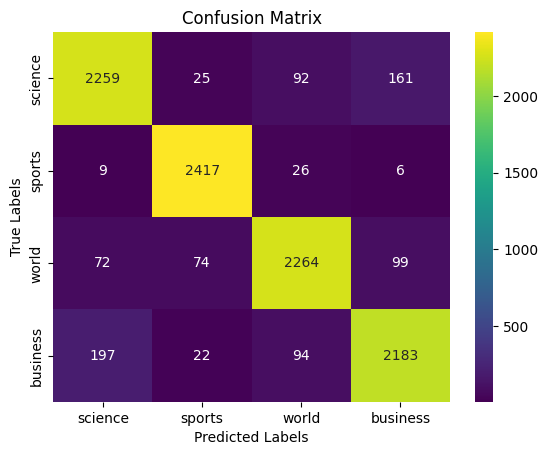

In [68]:
#And now, let's keep up the consistency and print for this model the classification report and the
#confusion matrix

#We extract the best model with its correspondent hyperparameters first.
sgd_best=sgd_grid.best_estimator_
print('Best Parameters:', sgd_grid.best_params_)

results_multiclass(model_fit=sgd_best)

So, up to here, we can draw intermediate conclusions for our ```SGDClassifier()```:

1. Sports is by far the best capture class when fitting our models, business, the worst.
2. Trigrams really do help, as it adds more information to the classifier when 3 types of words are bundled together.
3. A certain level of regularization helps us reduce overfitting and improve the semantics reading in unseen data.

Nonetheless, this does not tell us a lot about each single category! Binarizing the problem, that is, targeting the target feature for each actegory, may help in extracting the semantics for each one!

<div class="alert alert-block alert-danger">
<b>Second conclusion:</b> Business is the category that is less caught inside our notebook. Sports is by far the best one. We will try repeating the process for all four categories alone so that we see if redirecting our efforts could help.
</div>

###  ```SGDClassifier()``` for all four categories ###

#### Science ####

We will, here and in the subsequent labels, make use of the previous GridSearchCV structure, changing our target feature.

In [94]:
sgd_grid.fit(train.text, train.science_int)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        SGDClassifier(max_iter=100,
                                                      random_state=42,
                                                      tol=None))]),
             n_jobs=-1,
             param_grid={'clf__alpha': (0.001, 1e-06, 1e-09, 1e-12),
                         'vect__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             verbose=1)

Best Parameters: {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 3)}
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      7463
           1       0.89      0.88      0.88      2537

    accuracy                           0.94     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.94      0.94      0.94     10000



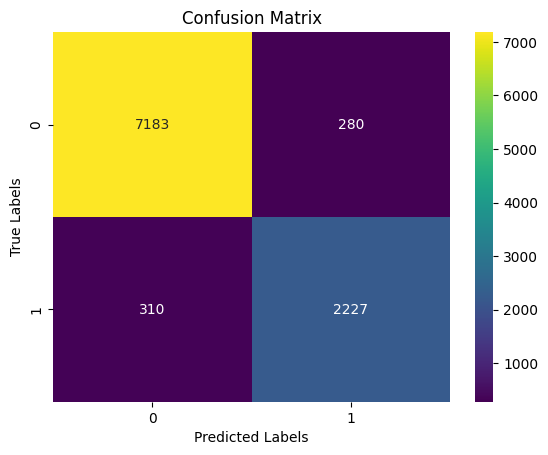

In [95]:
#We extract the best model with its correspondent hyperparameters first.
sgd_best=sgd_grid.best_estimator_
print('Best Parameters:', sgd_grid.best_params_)

results_binary(model_fit=sgd_best, variable="science_int")

#### Sports ####

In [96]:
sgd_grid.fit(train.text, train.sports_int)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        SGDClassifier(max_iter=100,
                                                      random_state=42,
                                                      tol=None))]),
             n_jobs=-1,
             param_grid={'clf__alpha': (0.001, 1e-06, 1e-09, 1e-12),
                         'vect__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             verbose=1)

Best Parameters: {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 3)}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7542
           1       0.96      0.98      0.97      2458

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



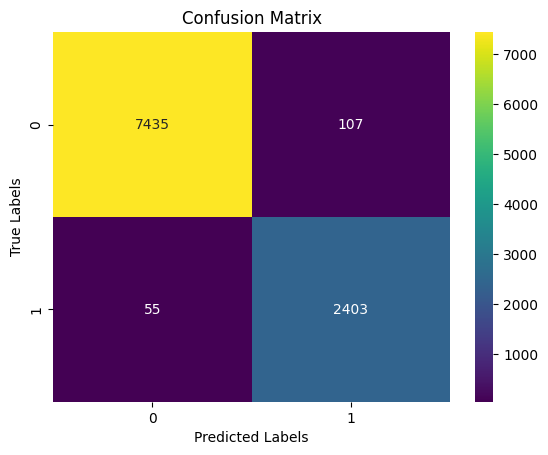

In [97]:
#We extract the best model with its correspondent hyperparameters first.
sgd_best=sgd_grid.best_estimator_
print('Best Parameters:', sgd_grid.best_params_)

results_binary(model_fit=sgd_best, variable="sports_int")

#### World ####

In [98]:
sgd_grid.fit(train.text, train.world_int)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        SGDClassifier(max_iter=100,
                                                      random_state=42,
                                                      tol=None))]),
             n_jobs=-1,
             param_grid={'clf__alpha': (0.001, 1e-06, 1e-09, 1e-12),
                         'vect__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             verbose=1)

Best Parameters: {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 3)}
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      7491
           1       0.92      0.89      0.90      2509

    accuracy                           0.95     10000
   macro avg       0.94      0.93      0.94     10000
weighted avg       0.95      0.95      0.95     10000



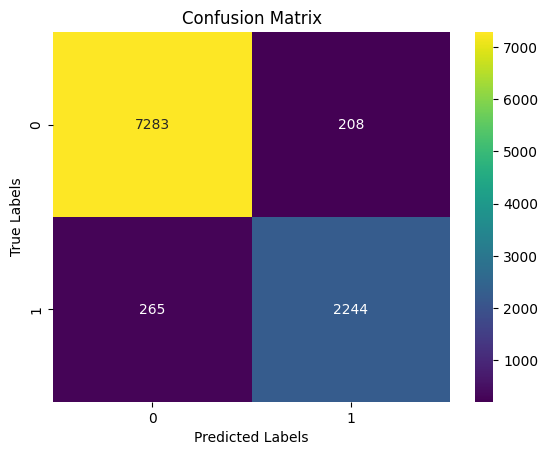

In [99]:
#We extract the best model with its correspondent hyperparameters first.
sgd_best=sgd_grid.best_estimator_
print('Best Parameters:', sgd_grid.best_params_)

results_binary(model_fit=sgd_best, variable="world_int")

#### Business ####

In [100]:
sgd_grid.fit(train.text, train.business_int)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        SGDClassifier(max_iter=100,
                                                      random_state=42,
                                                      tol=None))]),
             n_jobs=-1,
             param_grid={'clf__alpha': (0.001, 1e-06, 1e-09, 1e-12),
                         'vect__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             verbose=1)

Best Parameters: {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 3)}
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      7504
           1       0.90      0.87      0.88      2496

    accuracy                           0.94     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.94      0.94      0.94     10000



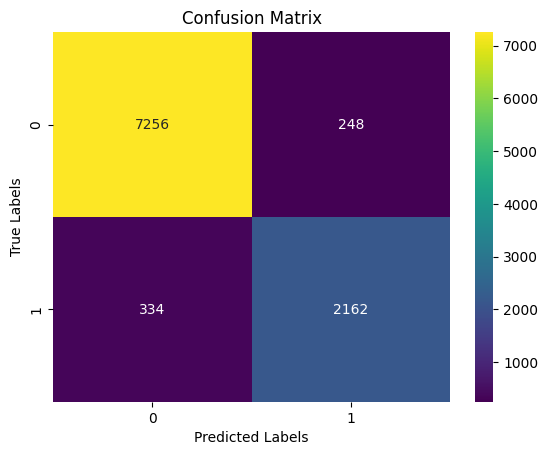

In [101]:
#We extract the best model with its correspondent hyperparameters first.
sgd_best=sgd_grid.best_estimator_
print('Best Parameters:', sgd_grid.best_params_)

results_binary(model_fit=sgd_best, variable="business_int")

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      7504
           1       0.90      0.87      0.88      2496

    accuracy                           0.94     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.94      0.94      0.94     10000



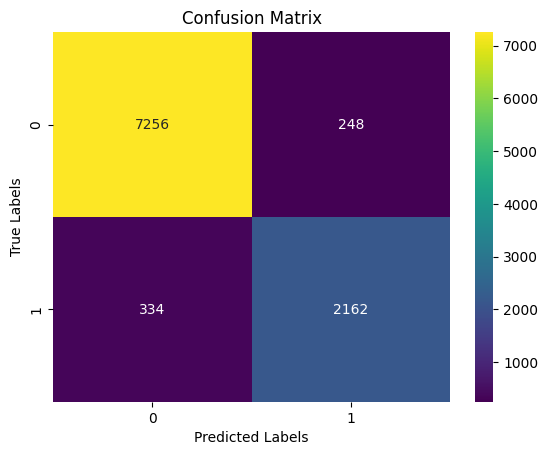

In [104]:
results_binary(model_fit=sgd_best, variable="business_int")

In [ ]:
def results_binary(model_fit, variable):
    predictions = model_fit.predict(test.text)

    # We print classification report
    report = classification_report(test[variable], predictions)
    print(report)

    # We also create a colourful confusion matrix
    cm = confusion_matrix(test[variable], predictions)
    cmap = "viridis"
    sns.heatmap(cm, annot=True, cmap=cmap, fmt="d")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Extract classification report values
    report_dict = classification_report(test[variable], predictions, output_dict=True)
    accuracy = report_dict['accuracy']
    precision = report_dict['1']['precision']
    recall = report_dict['1']['recall']

    return accuracy, precision, recall


# Store results for each category
category_results = {}

# Science
sgd_grid.fit(train.text, train.science_int)
sgd_best = sgd_grid.best_estimator_
print('Best Parameters:', sgd_grid.best_params_)
accuracy_science, precision_science, recall_science = results_binary(model_fit=sgd_best, variable="science_int")
category_results['science'] = (accuracy_science, precision_science, recall_science)

# Sports
sgd_grid.fit(train.text, train.sports_int)
sgd_best = sgd_grid.best_estimator_
print('Best Parameters:', sgd_grid.best_params_)
accuracy_sports, precision_sports, recall_sports = results_binary(model_fit=sgd_best, variable="sports_int")
category_results['sports'] = (accuracy_sports, precision_sports, recall_sports)

# World
sgd_grid.fit(train.text, train.world_int)
sgd_best = sgd_grid.best_estimator_
print('Best Parameters:', sgd_grid.best_params_)
accuracy_world, precision_world, recall_world = results_binary(model_fit=sgd_best, variable="world_int")
category_results['world'] = (accuracy_world, precision_world, recall_world)

# Business
sgd_grid.fit(train.text, train.business_int)
sgd_best = sgd_grid.best_estimator_
print('Best Parameters:', sgd_grid.best_params_)
accuracy_business, precision_business, recall_business = results_binary(model_fit=sgd_best, variable="business_int")
category_results['business'] = (accuracy_business, precision_business, recall_business)

# Plotting the bar chart
categories = ['science', 'sports', 'world', 'business']
metrics = ['Accuracy', 'Precision', 'Recall']

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
opacity = 0.8
index = np.arange(len(categories))

# Plotting accuracy
accuracy_values = [category_results[category][0] * 100 for category in categories]
rects_accuracy = ax.bar(index, accuracy_values, bar_width, alpha=opacity, color='b', label='Accuracy')

# Plotting precision
precision_values = [category_results[category][1] for category in categories]
rects_precision = ax.bar(index + bar_width, precision_values, bar_width, alpha=opacity, color='g', label='Precision')

# Plotting recall
recall_values = [category_results[category][2] for category in categories]
rects_recall = ax.bar(index + 2 * bar_width, recall_values, bar_width, alpha=opacity, color='r', label='Recall')

# Adding labels and title
ax.set_xlabel('Categories')
ax.set_ylabel('Metrics')
ax.set_title('Metrics for Each Category')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(categories)
ax.legend()

# Adding percentage values on top of each bar
for rect_acc, rect_prec, rect_rec in zip(rects_accuracy, rects_precision, rects_recall):
    height_acc = rect_acc.get_height()
    height_prec = rect_prec.get_height()
    height_rec = rect_rec.get_height()
    ax.text(rect_acc.get_x() + rect_acc.get_width() / 2., height_acc, f'{height_acc:.0f}%', ha='center', va='bottom')
    ax.text(rect_prec.get_x() + rect_prec.get_width() / 2., height_prec, f'{height_prec:.0f}', ha='center', va='bottom')
    ax.text(rect_rec.get_x() + rect_rec.get_width() / 2., height_rec, f'{height_rec:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Fitting 5 folds for each of 12 candidates, totalling 60 fits


<div class="alert alert-block alert-info">
<b>SINGLE WORDS:</b> First thing we see: <b>space news, software and technology really do play a positive pivotal role in here in the classification! On the other hand, economic and financial words, as well as football also help by doing the exact same weighting, but inversed!<b></div>

In [ ]:
#We will bring up a new convenience function from the notebook in order to do such extraction
def sort_feature_weights(sk_pipe, fkey='vect', wkey='clf'):
    F = sk_pipe[fkey].get_feature_names_out()
    W = sk_pipe[wkey].coef_[0]
    return sorted(zip(F, W), key=lambda fw: fw[1])

#We call the function and sort them, extracting the top 20
sgd_best_weights=sort_feature_weights(sgd_best)
sgd_best_weights = sorted(sgd_best_weights, key=lambda fw: fw[1], reverse=True)
print("Weights associated with the correct classification of single-words.")
sgd_best_weights[:20]